In [51]:
import numpy as np
import pandas as pd
import scipy
from pprint import pprint

from PIL import Image

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Dataset
import time
import os
import random
import matplotlib.pyplot as plt

import copy

from model import Classifier
from model import CustomSubset

def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [52]:
from fedlab.utils.dataset.partition import CIFAR10Partitioner
from fedlab.utils.dataset import FMNISTPartitioner
from fedlab.utils.dataset import MNISTPartitioner
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor(),
    # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [53]:
def diff(origin_net, update_net):
    grad = {}
    ori_params = origin_net.state_dict()
    new_params = update_net.state_dict()
    for k in new_params:
        grad[k] = new_params[k] - ori_params[k]
    return grad

def update(net, grad):
    params = net.state_dict()
    for k in params:
        params[k] = params[k] + grad[k]
    net.load_state_dict(params, strict=True)
    return net

def fedavg(net, clientGrads, clientN, samples):
    sum_grad = {}
    sample_nums = 0.0
    for i in samples:
        sample_nums += i
    weights = [i/sample_nums for i in samples]
    for k in clientGrads[0]:
        sum = 0
        for cId in range(clientN):
            sum = sum + clientGrads[cId][k]*weights[cId]
        sum_mean = sum
        sum_grad[k] = sum_mean
    return update(net, sum_grad)

def justavg(net, clientGrads, clientN, samples):
    sum_grad = {}
    sample_nums = 0.0
    for i in samples:
        sample_nums += i
    weights = [i/sample_nums for i in samples]
    for k in clientGrads[0]:
        sum = 0
        for cId in range(clientN):
            sum = sum + clientGrads[cId][k]
        sum_mean = sum/clientN
        sum_grad[k] = sum_mean
    return update(net, sum_grad)

aggregate = fedavg

criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()

In [54]:
class Client:
    def __init__(self, id, arch, dst, arch_addr, dst_addr, server_addr, device, criterion, optimizer="SGD", lr=0.01, epoch=1, communication_profile="local"):
        self.id = id
        self.arch = arch
        self.dst = dst
        self.arch_addr = arch_addr
        self.dst_addr = dst_addr
        self.server_addr = server_addr
        self.device = device
        self.optimizer = optimizer
        self.lr = lr
        self.epoch = epoch
        self.criterion = criterion
        self.commu = communication_profile
        if self.commu == "local":
            self.recv_net = self.recv_net_local
            self.recv_dst = self.recv_dst_local
            self.recv_task = self.recv_task_local
            self.send_grad = self.send_grad_local
        return

    def recv_net_local(self):
        net = copy.deepcopy(self.arch_addr)
        net.to(self.device)
        return net
    
    def recv_dst_local(self):
        data_loader = self.dst_addr
        return data_loader
    
    def train(self, net, dst_loader):
        if self.optimizer == "SGD":
            optimizer = torch.optim.SGD(net.parameters(), lr=self.lr)
        net.train()
        for epoch in range(self.epoch):
            for i, data in enumerate(dst_loader):
                if data[0].size()[0] == 1:
                    continue
                optimizer.zero_grad()
                train_pred = net(data[0].to(self.device))
                batch_loss = self.criterion(train_pred, data[1].to(self.device))
                # using L1Loss as criterion
                # y = torch.zeros(data[1].size()[0],10)
                # for i in range(data[1].size()[0]):
                #     y[i][data[1][i]] = 1
                # batch_loss = self.criterion(F.softmax(train_pred, dim=1), y.to(self.device))
                batch_loss.backward()
                optimizer.step()
        origin_net = self.recv_net()
        with torch.no_grad():
            grad = diff(origin_net, net)
        return grad
    
    def send_grad_local(self, grad):
        self.server_addr.put((self.id, grad, self.dst_addr.dataset.__len__()))
    
    def recv_task_local(self):
        net = self.recv_net()
        dst_loader = self.recv_dst()
        grad = self.train(net, dst_loader)
        self.send_grad(grad)

In [55]:
class Server_Reciever:
    def __init__(self, communication_profile="local"):
        if communication_profile == "local":
            self.recieved = []
        else:
            exit(-1)
    def empty(self):
        return len(self.recieved) == 0
    def get(self):
        msg = self.recieved[0]
        self.recieved = self.recieved[1:]
        return msg
    def put(self, msg):
        self.recieved.append(msg)

In [56]:
def make_dloader(dst, dst_path):
    if dst == "MNIST":
        dset = torchvision.datasets.MNIST(root=dst_path, train=False, download=True, transform=transform)
    elif dst == "FMNIST":
        dset = torchvision.datasets.FashionMNIST(root=dst_path, train=False, download=True, transform=transform)
    elif dst == "CIFAR10":
        dset = torchvision.datasets.CIFAR10(root=dst_path, train=False, download=True, transform=transform)
    else:
        exit("No such dataset" + dst)
    dloader = DataLoader(dset, batch_size=32)
    return dloader

class Server:
    def __init__(self, arch, dst, dst_path, server_addr, partition, criterion, client_nums, participant_nums, round_nums, device, dir, seed, optimizer="SGD", lr=0.01, communication_profile="local", epoch=1, batch_size=32):
        self.net = Classifier(arch, dst).to(device)
        self.arch = arch
        self.dst=dst
        self.dst_path=dst_path
        self.partition = partition
        self.seed = seed
        self.criterion = criterion
        self.test_dst = make_dloader(dst, dst_path)
        self.client_nums = client_nums
        self.participant_nums = participant_nums
        self.round_nums = round_nums
        self.device = device
        self.scores = []
        self.clients = []
        self.round_counter = 0
        self.dir = dir
        self.server_addr = Server_Reciever(communication_profile=communication_profile)
        self.communication_profile = communication_profile
        self.logs = []
        if communication_profile == "local":
            real_id, client_dict, self.global_traindst = self.make_part()
        for i in range(client_nums):
            if self.partition == "iid" or self.partition == "label-skew":
                threshold = len(client_dict[real_id[i]]) * (client_nums - i-1)/(client_nums)
            else:
                threshold = 0
            threshold = len(client_dict[real_id[i]]) * (client_nums - i-1)/(client_nums)
            threshold /= 1 # reduce noise
            css = CustomSubset(self.global_traindst, client_dict[real_id[i]], i, threshold=threshold)
            dloader = DataLoader(css, batch_size=batch_size)
            c = Client(id=i, arch=arch, dst=dst, arch_addr=self.net, dst_addr=dloader, \
                       server_addr=self.server_addr, device=device, criterion=criterion, optimizer=optimizer, \
                       lr=lr, epoch=epoch, communication_profile=communication_profile)
            self.clients.append(c)
    
    def make_part(self):
        if self.dst == "MNIST":
            trainset = torchvision.datasets.MNIST(root=self.dst_path, train=True, download=True, transform=transform)
            partitioner = MNISTPartitioner
        elif self.dst == "FMNIST":
            trainset = torchvision.datasets.FashionMNIST(root=self.dst_path, train=True, download=True, transform=transform)
            partitioner = FMNISTPartitioner
        elif self.dst == "CIFAR10":
            trainset = torchvision.datasets.CIFAR10(root=self.dst_path, train=True, download=True, transform=transform)
            partitioner = CIFAR10Partitioner
        else:
            exit("No such dataset" + self.dst)
        if self.dst == "CIFAR10":
            if self.partition == "iid":
                part = partitioner(trainset.targets,
                                      self.client_nums,
                                      balance=True,
                                      partition="iid",
                                      seed=self.seed)
            elif self.partition == "label-skew":
                part = partitioner(trainset.targets,
                                      self.client_nums,
                                      balance=True,
                                      partition="dirichlet",
                                      dir_alpha=0.3,
                                      seed=self.seed)
            elif self.partition == "quantity-skew":
                part = partitioner(trainset.targets,
                                      self.client_nums,
                                      balance=False,
                                      partition="iid",
                                      unbalance_sgm=0.7,
                                      seed=self.seed)
            else:
                exit("No such partition")
        else:
            if self.partition == "iid":
                part = partitioner(trainset.targets,
                                      self.client_nums,
                                      partition="iid",
                                      seed=self.seed)
            elif self.partition == "label-skew":
                part = partitioner(trainset.targets,
                                      self.client_nums,
                                      partition="noniid-#label",
                                      major_classes_num=5,
                                      dir_alpha=0.7,
                                      seed=self.seed)
            elif self.partition == "quantity-skew":
                part = partitioner(trainset.targets,
                                      self.client_nums,
                                      partition="unbalance",
                                      dir_alpha=0.7,
                                      seed=self.seed)
            else:
                exit("No such partition")
        x = [(i, len(part.client_dict[i])) for i in part.client_dict]
        # x = sorted(x, key = lambda t: t[1])
        self.part = part
        return [i[0] for i in x], part.client_dict, trainset
    
    def select_clients(self):
        return np.random.choice(self.client_nums, self.participant_nums, False).tolist()
    
    def test(self):
        test_acc = 0.0
        test_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(self.test_dst):
                test_pred = self.net(data[0].to(self.device))
                batch_loss = self.criterion(test_pred, data[1].to(self.device))
                # y = torch.zeros(data[1].size()[0],10)
                # for i in range(data[1].size()[0]):
                #     y[i][data[1][i]] = 1
                # batch_loss = self.criterion(F.softmax(test_pred, dim=1), y.to(self.device))

                test_acc += np.sum(np.argmax(test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
                test_loss += batch_loss.item()
        return test_acc/self.test_dst.dataset.__len__(), test_loss/self.test_dst.dataset.__len__()
    
    def new_round_train(self):
        participants = self.select_clients()
        grads = []
        samples = []
        state = []
        for i in participants:
            self.clients[i].recv_task()
        while not self.server_addr.empty():
            id, grad, sample_nums = self.server_addr.get()
            if grad != None:
                state.append((id, True))
                grads.append(grad)
                samples.append(sample_nums)
            else:
                state.append((id, False))
                samples.append(sample_nums)
        self.net = aggregate(self.net, grads, self.participant_nums, samples)
        acc, loss = self.test()
        log_of_this_round = {
            "round": self.round_counter,
            "participants": tuple(participants),
            "state": tuple(state),
            "accuracy": acc,
            "loss": loss
        }
        self.logs.append(log_of_this_round)
        self.round_counter += 1
    
    def run(self):
        for i in range(self.round_nums):
            start_time = time.time()
            self.new_round_train()
            end_time = time.time()
            print('[%03d/%03d round] Test Acc: %3.6f Loss: %3.6f Time: %3.6f' % (self.round_counter,
                                                                     self.round_nums, 
                                                                     self.logs[-1]["accuracy"],
                                                                     self.logs[-1]["loss"],
                                                                     end_time-start_time))
        meta = {'arch': self.arch, 'dst':self.dst, 'client_num':self.client_nums, 
                'participant_nums': self.participant_nums, 'round_nums':self.round_nums,
                'partition':self.partition, 'seed':self.seed}
        
        torch.save({'logs':self.logs, 'meta':meta}, self.dir + ".dict")
        

In [57]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
seed = 1
setup_seed(seed)
s = Server(arch="MOBILENETV2", dst="CIFAR10", dst_path="./data", server_addr="",partition="label-skew",
           criterion=criterion, client_nums=100, participant_nums=10, round_nums=2, device="cuda",
           dir="./test", seed=seed)
# s.run()

Files already downloaded and verified
Files already downloaded and verified
Remaining Data: 50000
Remaining Data: 49999
Remaining Data: 49998
Remaining Data: 49997
Remaining Data: 49996
Remaining Data: 49995
Remaining Data: 49994
Remaining Data: 49993
Remaining Data: 49992
Remaining Data: 49991
Remaining Data: 49990
Remaining Data: 49989
Remaining Data: 49988
Remaining Data: 49987
Remaining Data: 49986
Remaining Data: 49985
Remaining Data: 49984
Remaining Data: 49983
Remaining Data: 49982
Remaining Data: 49981
Remaining Data: 49980
Remaining Data: 49979
Remaining Data: 49978
Remaining Data: 49977
Remaining Data: 49976
Remaining Data: 49975
Remaining Data: 49974
Remaining Data: 49973
Remaining Data: 49972
Remaining Data: 49971
Remaining Data: 49970
Remaining Data: 49969
Remaining Data: 49968
Remaining Data: 49967
Remaining Data: 49966
Remaining Data: 49965
Remaining Data: 49964
Remaining Data: 49963
Remaining Data: 49962
Remaining Data: 49961
Remaining Data: 49960
Remaining Data: 49959


In [60]:
s.run()

[003/002 round] Test Acc: 0.118600 Loss: 0.071845 Time: 10.433416
[004/002 round] Test Acc: 0.133400 Loss: 0.071469 Time: 10.431745


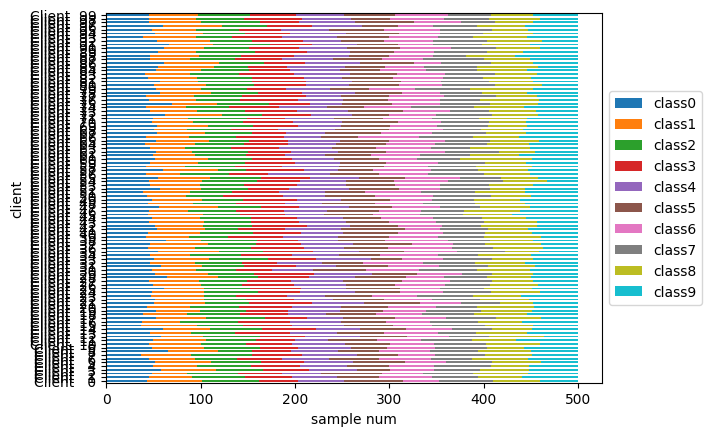

In [58]:
from fedlab.utils.functional import partition_report
col_names = [f"class{i}" for i in range(10)]

# perform partition
noniid_major_label_part = s.part

# generate partition report
csv_file = "./report.csv"
partition_report(s.global_traindst.targets, noniid_major_label_part.client_dict, 
                 class_num=10, 
                 verbose=False, file=csv_file)

noniid_major_label_part_df = pd.read_csv(csv_file,header=1)
noniid_major_label_part_df = noniid_major_label_part_df.set_index('client')
for col in col_names:
    noniid_major_label_part_df[col] = (noniid_major_label_part_df[col] * noniid_major_label_part_df['Amount']).astype(int)

# select first 10 clients for bar plot
noniid_major_label_part_df[col_names].plot.barh(stacked=True)  
# plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('sample num')
plt.show()

In [ ]:
for c in s.clients:
    print(c.dst_addr.dataset.__len__())

In [9]:
def score_by_log_ace(logs, client_num, bound=3, beta=0.2):
    round_num = len(logs)
    scores = [[0 for i in range(client_num)]]
    for r in range(1, round_num):
        participants = logs[r]['participants']
        accuracy = logs[r]['accuracy']
        prev_accuracy = logs[r-1]['accuracy']
        last_round_scores = copy.deepcopy(scores[-1])
        if r >= bound:
            lowbound = r - bound
        else:
            lowbound = 0
        expected_accuracy = np.average([logs[i]['accuracy'] for i in range(lowbound, r)])
        diff1 = accuracy - prev_accuracy
        diff2 = accuracy - expected_accuracy
        s = 0
        if diff1 * diff2 > 0:
            s = (1 + prev_accuracy)**25 * (diff1)
        for cid in participants:
            last_round_scores[cid] += s
        scores.append(last_round_scores)
    return scores

def score_by_log_baseline(logs, client_num):
    round_num = len(logs)
    scores = [[0 for i in range(client_num)]]
    for r in range(1, round_num):
        participants = logs[r]['participants']
        accuracy = logs[r]['accuracy']
        prev_participants = logs[r-1]['participants']
        prev_accuracy = logs[r-1]['accuracy']
        last_round_scores = copy.deepcopy(scores[-1])
        if r > 1:
            if accuracy - prev_accuracy > prev_accuracy - logs[r-2]['accuracy']:
                for cid in prev_participants:
                    last_round_scores[cid] -= 1
                for cid in participants:
                    last_round_scores[cid] += 1
        if accuracy < prev_accuracy:
            for cid in participants:
                last_round_scores[cid] -= 1
        scores.append(last_round_scores)
    return scores

def calc_spearman(scores, client_num):
    co = []
    y = [c for c in range(client_num)]
    for x in scores:
        spearman=scipy.stats.spearmanr(x,y)[0]
        co.append(spearman)
    return co


In [10]:
# def getAccuracy(arch, dst, part, seed, client_num):
#     logs = torch.load("fedace_data/" + "-".join((str(seed), arch, dst, part, str(client_num)))+".dict")['logs']
#     accuracy = [i['accuracy'] for i in logs]
#     return accuracy
# nets = ['CNN']
# dsts = ['CIFAR10', 'MNIST', 'FMNIST']
# parts = ['iid', 'label-skew', 'quantity-skew']
# client_nums = [5, 25, 100]
# fig1 = plt.figure(figsize=(16,8), dpi=300)
# axs = fig1.subplots(len(dsts), len(client_nums))
# seed = 1
# part = parts[1]
# x = [i for i in range(100)]
# for netId in range(len(nets)):
#     for dstId in range(len(dsts)):
#         for cnId in range(len(client_nums)):
#             accuracy = getAccuracy(nets[netId], dsts[dstId], part, seed, client_nums[cnId])
#             ax = axs[dstId][cnId]
#             ax.plot(x, accuracy)
#             ax.set_title("-".join([nets[netId], dsts[dstId], str(client_nums[cnId])]))
# fig1.show()

/HARD-DRIVE/ZLL/anaconda3/envs/AI/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/HARD-DRIVE/ZLL/anaconda3/envs/AI/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/HARD-DRIVE/ZLL/anaconda3/envs/AI/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/HARD-DRIVE/ZLL/anaconda3/envs/AI/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/HARD-DRIVE/ZLL/anaconda3/envs/AI/li

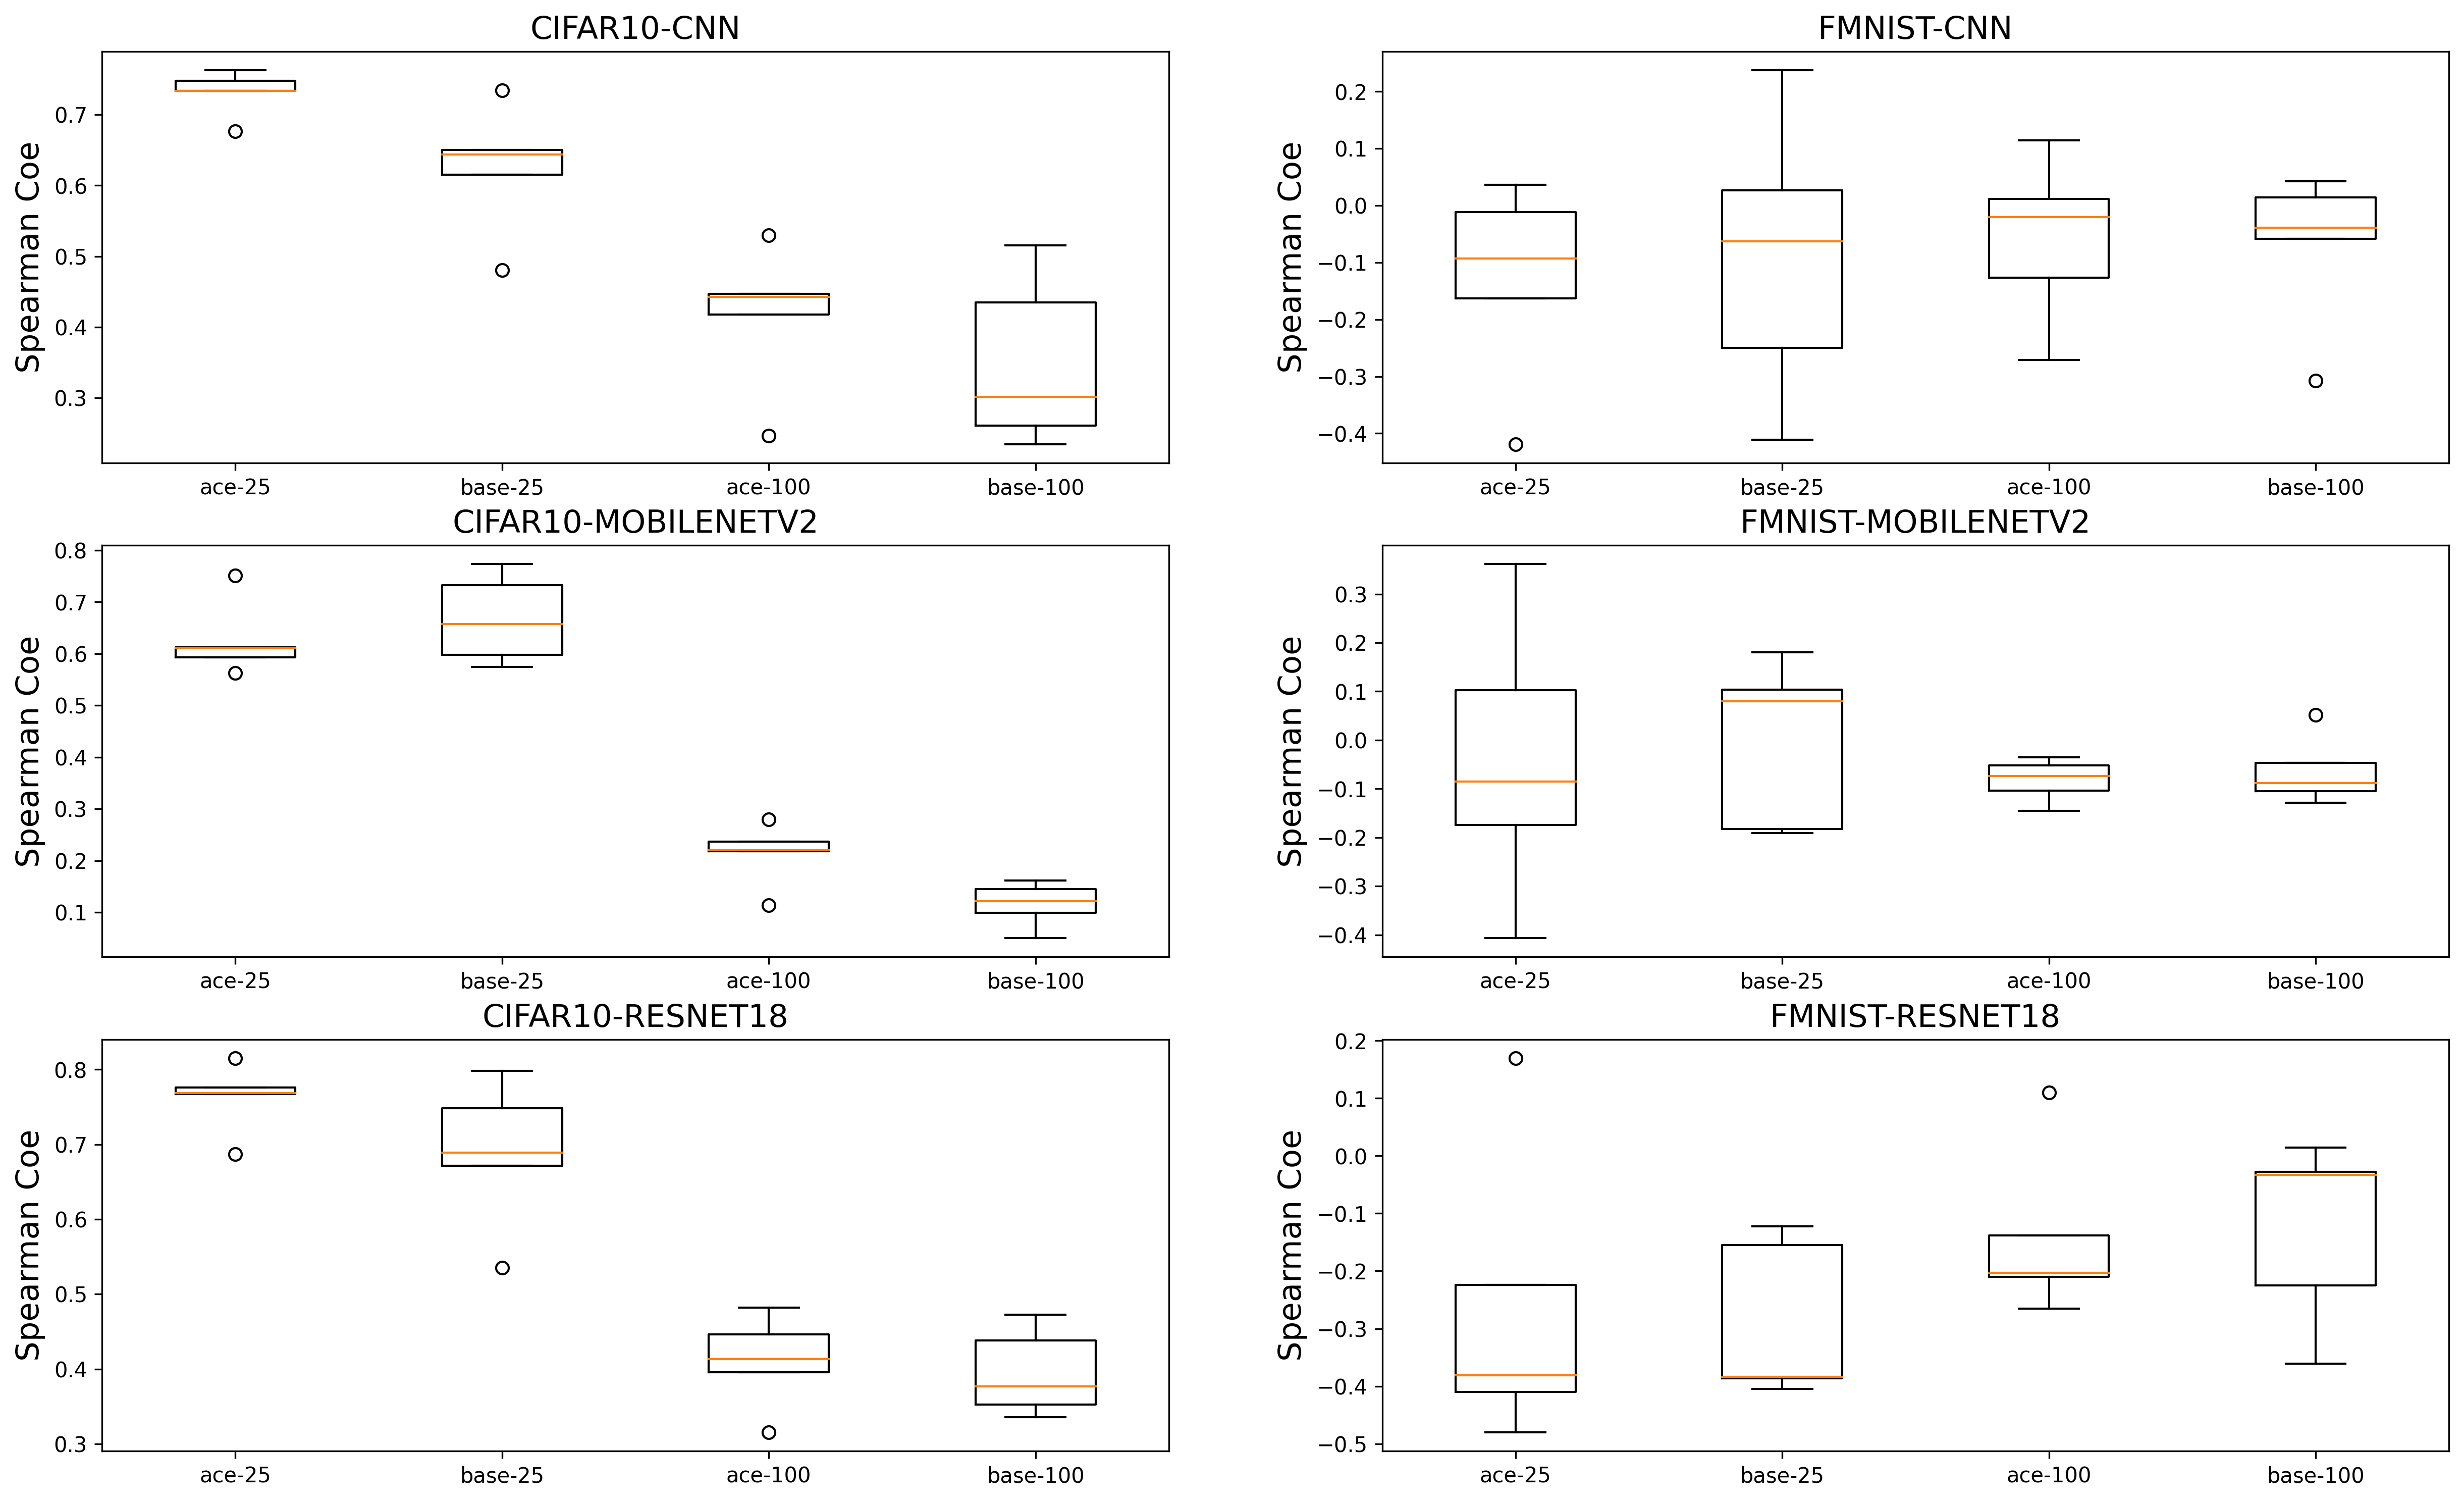

In [137]:
def getScores(arch, dst, part, seeds, client_nums=[5, 25, 100]):
    dlists = []
    labels = []
    for cs in client_nums:
        ace = []
        base = []
        for seed in seeds:
            logs = torch.load("fedace_new_data/" + "-".join((str(seed), arch, dst, part, str(cs)))+".dict")['logs']
            scores_ace = score_by_log_ace(logs, cs, bound=5)
            scores_baseline = score_by_log_baseline(logs, cs)
            coace = calc_spearman(scores_ace, cs)
            cobaseline = calc_spearman(scores_baseline, cs)
            if pd.isna(coace[-1]) or pd.isna(cobaseline[-1]):
                continue
            # if coace[-1] < 0:
            #     continue
            ace.append(coace[-1])
            base.append(cobaseline[-1])
        dlists.append(ace)
        labels.append("ace"+"-"+str(cs))
        dlists.append(base)
        labels.append("base"+"-"+str(cs))
    return dlists, labels
fig2 = plt.figure(figsize=(20,12), dpi=300)
nets = ['CNN', 'MOBILENETV2', 'RESNET18']
dsts = ['CIFAR10', 'FMNIST']
# dsts = ['CIFAR10']
axs = fig2.subplots(len(nets), len(dsts))
part = "label-skew"
for netId in range(len(nets)):
    for dstId in range(len(dsts)):
        dlists, labels = getScores(nets[netId], dsts[dstId], part, [i for i in range(1, 6)], [25, 100])
        if len(nets)== 1 and len(dsts)==1:
            ax = axs
        elif len(nets) == 1:
            ax = axs[dstId]
        elif len(dsts) == 1:
            ax = axs[netId]
        else:
            ax = axs[netId][dstId]
        ax.boxplot(dlists,labels=labels)
        ax.set_title(dsts[dstId] + "-" + nets[netId])
        ax.set_ylabel('Spearman Coe')
        ax.yaxis.label.set_fontsize(15)
        ax.title.set_size(15)

fig2.show()
# fig2.savefig("./fig2.pdf", bbox_inches='tight')

In [22]:
pd.isna(dlists[0][1])

True

In [158]:
arch = "CNN"
dst = "CIFAR10"
part = "label-skew"
cs = 100
seed = 5
logs = torch.load("fedace_data/" + "-".join((str(seed), arch, dst, part, str(cs)))+".dict")['logs']
scores_ace = score_by_log_ace(logs, cs)
scores_baseline = score_by_log_baseline(logs, cs)
coace = calc_spearman(scores_ace, cs)
cobaseline = calc_spearman(scores_baseline, cs)
coace[-1], cobaseline[-1]

(-0.15525952595259523, -0.04444426614971324)

(-0.04831683168316832, 0.04902532313015502)

In [ ]:
for c in s.clients:
    print(c.dst_addr.dataset.threshold, len(c.dst_addr.dataset.indices))